## Model Comparison

#### Imports

In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.api import keras

from hpcscripts.sharedutils.nomalization import *
from hpcscripts.trainers.windowmanager import WindowGenerator
from hpcscripts.sharedutils.trainingutils import LoadModel, SetLowTFVerbose, MakeSinglePrediction, CreateWindowGenerator, ImportCombinedTrainingData, GetFileList
from hpcscripts.sharedutils.nomalization import DF_Nomalize, denorm
from hpcscripts.sharedutils.modelutils import SelectModelPrompt
from hpcscripts.option import pathhandler as ph
from hpcscripts.option import globalparams as G_PARAMS

2022-08-29 19:23:40.100069: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-29 19:23:40.116838: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


#### Function Definitions

In [2]:
# Get Training Data to calculate norm param
train_file = os.path.join(ph.GetProcessedPath("Combined"), "Train_set.csv")
train_data, NORM_PARAM = DF_Nomalize(pd.read_csv(train_file))

# Make TensorFlow Quiet
SetLowTFVerbose()

# rad2deg
rad2deg = 180 / math.pi

labels = G_PARAMS.SEQUENTIAL_LABELS

In [3]:
def get_file_list():
    train_dir = ph.GetProcessedPath("Selected")
    test_dir  = ph.GetProcessedPath("Test")

    train_list = os.listdir(train_dir)
    test_list  = os.listdir(test_dir)

    for i, test_file in enumerate (test_list):
        train_list.remove(test_file)
        test_list[i] = os.path.join(test_dir, test_file)

    for i, train_file in enumerate (train_list):
        train_list[i] = os.path.join(train_dir, train_file)

    return train_list, test_list

In [4]:
def Predict(filename: str, model, window, modelsmeta, NORM_PARAM=NORM_PARAM):
    G_PARAMS.SetParams(modelsmeta['param'])
    prediction_dict = {}
    file_path = os.path.join (ph.GetProcessedPath("Test"), filename)

    test_df, predictions = MakeSinglePrediction(file_path, model, window)

    for i, label in enumerate(labels):
        z, s = NORM_PARAM[label]
        zt,st= NORM_PARAM["time_s"]

        denormed_time  = denorm(test_df["time_s"].to_numpy(), zt, st)
        denormed_label = denorm(test_df[label], z, s)
        denormed_pred  = denorm(predictions[:, i], z, s)

        if (label.endswith("rad")):
            denormed_pred = denormed_pred * rad2deg
            denormed_label= denormed_label* rad2deg

        prediction_dict[label] = (denormed_label, denormed_pred)
    
    return denormed_time, prediction_dict

def ShowPrediction(filename: str, model, window, modelsmeta, NORM_PARAM=NORM_PARAM,
                win_start: int=0, win_end: int=-1
):
    denormed_time, prediction_dict = Predict(filename, model, window, NORM_PARAM)

    for i, label in enumerate(labels):
        denormed_label, denormed_pred = prediction_dict[label]

        # plt.plot(denormed_time[win_start:win_end], denormed_label[win_start:win_end])
        plt.scatter(denormed_time[win_start:win_end], denormed_label[win_start:win_end], c='r', marker='X')
        plt.scatter(denormed_time[win_start:win_end], denormed_pred[win_start:win_end], c='b', marker='*')

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

def ShowComparison(filename: str, model, window, NORM_PARAM=NORM_PARAM,
                win_start: int=0, win_end: int=-1
):
    denormed_time, prediction_dict = Predict(filename, model, window, NORM_PARAM)

    for i, label in enumerate(labels):
        denormed_label, denormed_pred = prediction_dict[label]

        label_min = float (denormed_label[win_start:win_end].min())
        label_max = float (denormed_label[win_start:win_end].max())
        eq_line = np.linspace(label_min, label_max, denormed_label[win_start:win_end].shape[0])

        # plt.plot(denormed_time[win_start:win_end], denormed_label[win_start:win_end])
        plt.scatter(denormed_label[win_start:win_end], denormed_pred[win_start:win_end], c='r', marker='X')
        plt.plot(eq_line, eq_line)

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

#### Window Generator

In [5]:
def NewWindowGenerator ():
    train_list, test_list = get_file_list()

    pred_window = CreateWindowGenerator(
                        train_list=test_list,
                        test_list=test_list, eval_list=None,
                        norm_param=NORM_PARAM
                    )

    return pred_window

#### Class Definition

In [32]:
class ModelContainer:
    def __init__(self, model: tf.keras.Model, history: dict, modelsmeta: dict, model_dir:str, name: str):
        self.model = model
        self.history = history
        self.modelsmeta = modelsmeta
        self.name = name
        self.model_dir = model_dir
        
        G_PARAMS.SetParams(self.modelsmeta['param'])
        self.window = NewWindowGenerator()
        self.CalculatePerformanceMeasure()

    def PlotTrainHistory(self, metric='mean_absolute_error', savepath=''):
        G_PARAMS.SetParams(self.modelsmeta['param'])

        epochs = [a+1 for a in range(len(self.history['loss']))]

        plt.plot(epochs, self.history[metric])
        plt.plot(epochs, self.history['val_{}'.format(metric)])

        plt.xlabel("epoch")
        plt.ylabel(metric)
        plt.title("{} Model's Training History".format(self.name))
        plt.legend([metric, 'val_{}'.format(metric)])

        if len(savepath) > 0:
            plt.savefig(savepath)

        plt.show()

    def PredictFile(self, filename: str,
                #win_start: int=0, win_end: int=-1
    ):
        denormed_time, prediction_dict = Predict(
                    filename, 
                    self.model, self.window, 
                    self.modelsmeta, 
                    NORM_PARAM=self.window.norm_param
            )

        return denormed_time, prediction_dict 

    def CalculatePerformanceMeasure(self):
        print ("Begin Performance Evaluation for {} Model".format(self.model_dir))
        # Check r2 results
        r2csv_path = os.path.join(self.model_dir, "r2.csv")
        if not os.path.exists(r2csv_path):
            print ('can\' found r2.csv for {}'.format(self.model_dir))
        else:
            self.r2_df = pd.read_csv(r2csv_path)

        # Unnormalize MAE (TEST)
        self.unnorm_elv_mae = self.r2_df['mae_elv_l_deg'].mean()
        self.unnorm_n1s_mae = self.r2_df['mae_N1s_rpm'].mean()

        # Eval Performance
        epochs = [a+1 for a in range(len(self.history['loss']))]
        self.eval_mse = self.history['val_mean_squared_error'][-1]
        self.eval_mae = self.history['val_mean_absolute_error'][-1]

        # Test Performance
        test_performance = self.model.evaluate(self.window.test)
        self.test_mse = test_performance[1]
        self.test_mae = test_performance[2]

        print ("Finished Performance Evaluation for {}".format(self.model_dir))

#### Plotting Definitions

In [7]:
from typing import List


def PlotPerformanceComparison(model_containers: List[ModelContainer], width = 0.3):

    fig = plt.figure(constrained_layout=True)
    
    rows = 1
    cols = 2

    gs = fig.add_gridspec(rows, cols)

    # Order model containers
    model_containers.sort(key=lambda x: x.test_mae, reverse=True)

    val_mae = []
    val_mse = []
    test_mae = []
    test_mse = []
    names = []
    for container in model_containers:
        names.append(container.name)
        val_mse.append(container.eval_mse)
        val_mae.append(container.eval_mae)
        test_mse.append(container.test_mse)
        test_mae.append(container.test_mae)

    # MSE
    ax = fig.add_subplot(gs[0, 0])
    x = np.arange(len(model_containers))

    ax.bar(x - (width/2 + 0.02), val_mse, width, label='Validation', color='#202124')
    ax.bar(x + (width/2 + 0.02), test_mse, width, label='Test', color='lightgray')
    ax.set_xticks(ticks=x, labels=names,
            rotation=45)
    ax.set_ylabel(f'MSE (average over all times and outputs)')
    _ = plt.legend()
    
    ax.set_ylim((0, 0.63))
    ax.grid()

    # MAE
    ax = fig.add_subplot(gs[0, 1])

    ax.bar(x - (width/2 + 0.02), val_mae, width, label='Validation', color='#202124')
    ax.bar(x + (width/2 + 0.02), test_mae, width, label='Test', color='lightgray')
    ax.set_xticks(ticks=x, labels=names,
            rotation=45)
    ax.set_ylabel(f'MAE (average over all times and outputs)')
    _ = plt.legend()

    ax.set_ylim((0, 0.63))
    ax.grid()


    fig.set_size_inches(18/5*cols, 3*rows)
    fig.suptitle("Tuned Models Performance in MSE and MAE\n")

    fig.savefig('figs/ch4_mse_and_mae_tuned_models.png', dpi=400)
    fig.show()


In [8]:
from math import floor
import random


def PlotRandomSamplePredictions(filelist, model_containers: List[ModelContainer], r: int = 4, c: int = 2, num: int = 1):
    
    if len(filelist) < 1: # r*c:
        print ("Not enough files in the list")
        return
    rand_list = random.sample(filelist, 1)

    fig = plt.figure(constrained_layout=True)
    
    left_count = floor((len(model_containers)-1)/2)
    left_containers =  model_containers[1:(1+left_count)]
    right_containers = model_containers[(1+left_count):]

    left_style = [
        ('dashed', None),
        ('solid', 'X'),
        ('solid', 's')
    ]
    right_style = [
        ('dashed', None),
        ('solid', 'o'),
        ('solid', '^')
    ]
    
    label_count = len(G_PARAMS.SEQUENTIAL_LABELS)
    rows = 1
    cols = 2*1

    gs = fig.add_gridspec(rows*label_count, cols)

    i = 0
    flightname = rand_list[0]
    for j in range(cols):
        current_containers = [left_containers, right_containers][j]
        current_style = [left_style, right_style][j]
        for i in range(rows):

            prediction_tuples = []
            largest_length = 0
            label_tuple = ()
            for k, container in enumerate([model_containers[0]] + current_containers):
                print (os.path.basename(container.model_dir))
                denormed_time, prediction_dict = container.PredictFile(
                                                filename=flightname
                                            )
                
                prediction_tuples.append((denormed_time, prediction_dict))

                if denormed_time.shape[0] > largest_length:
                    largest_length = denormed_time.shape[0]
                    label_tuple = (denormed_time, prediction_dict)

            # Plot every labels for one flight

            for sr in range(label_count):
                label_index = sr
                label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

                label_time, label_dict = label_tuple
                denormed_label, _ = label_dict[label]

                ax = fig.add_subplot(gs[i*label_count + sr, j])
                ax.plot (label_time, denormed_label, linestyle='solid', color = 'k', linewidth=1.5)

                for k, pred_tuple in enumerate(prediction_tuples):
                    denormed_time, prediction_dict = pred_tuple
                    _, denormed_pred = prediction_dict[label]

                    linewidth = 1
                    linestyle, marker = current_style[k]
                    
                    if k == 0:
                        ax.plot (denormed_time, denormed_pred, linestyle=linestyle, linewidth=linewidth, color='k')
                    else:
                        pass
                        ax.plot (denormed_time, denormed_pred, linestyle=linestyle, linewidth=linewidth) # linestyle=linestyle_list[k]
                        
                    if marker:
                        period = 20
                        offset = (k-1)*10
                        # ax.scatter(denormed_time[offset::period], denormed_pred[offset::period])

                ax.grid()

            
                if label_index == 0:
                    ax.set_title(', '.join([os.path.basename(c.model_dir) for c in current_containers]))
                if label_index == label_count-1:
                    ax.set_xlabel("Time (s)")

                if j == 0 or j == 2:
                    ax.set_ylabel('\n'*j + label)
                
            ax.legend(["Test Data"] + [c.name for c in [model_containers[0]] + current_containers ])
            # if j == 1 or j == 3:
                

    flightname = os.path.basename(flightname)

    fig.set_size_inches(18/4*cols, 3*2*rows)
    fig.suptitle("Prediction For {} \n".format(flightname.removesuffix('.csv')))

    fig.savefig('figs/ch4_predictions_{}.png'.format(flightname.removesuffix('.csv')), dpi=400)
    fig.show()

#### Import Models

In [37]:
ModelFolders = ['Baseline', 'Dense_20', 'LSTM', 'GRU', 'Conv', 'Dense']
ModelNames = [r'Baseline', r'$Dense_{20}$', 'LSTM', 'GRU', 'Conv', 'Dense']

models_parrent_dir = ph.GetModelsPath()

model_containers = []
for model_dir, model_name in zip(ModelFolders, ModelNames):
    try:
        # print (os.path.join(models_parrent_dir, model_dir))
        model, model_history, modelsmeta = LoadModel(os.path.join(models_parrent_dir, model_dir))
        container = ModelContainer(
                                model, 
                                model_history, modelsmeta,
                                os.path.join(models_parrent_dir, model_dir),
                                model_name
                            )
        model_containers.append(container)
    except Exception as e:
        print ("Can't Found {} Model".format(model_dir))
        print (e)


print ('Found {} Models: {}'.format(
                len(model_containers), 
                ', '.join([os.path.basename(c.model_dir) for c in model_containers]))
            )


model loaded
model history loaded
model metadata loaded
Begin Performance Evaluation for /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models/Baseline Model
508/508 [==============================] - 3s 6ms/step - loss: 0.5552 - mean_squared_error: 0.5552 - mean_absolute_error: 0.5048
Finished Performance Evaluation for /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models/Baseline
Can't Found Dense_20 Model
SavedModel file does not exist at: /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models/Dense_20/{saved_model.pbtxt|saved_model.pb}

model loaded
model history loaded
model metadata loaded
Begin Performance Evaluation for /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models/LSTM Model
464/464 [==============================] - 7s 12ms/step - loss: 0.4362 - mean_squared_error: 0.4362 - mean_absolute_error: 0.4250
Finished Performance Evaluation for /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models/LSTM

model loaded
model history loaded
model metadat

#### Models' Summary

##### Plot Training Hisotry

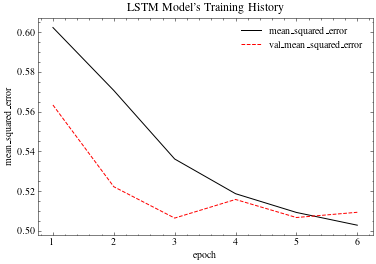

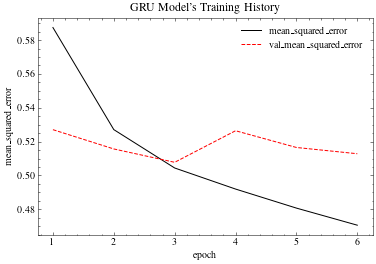

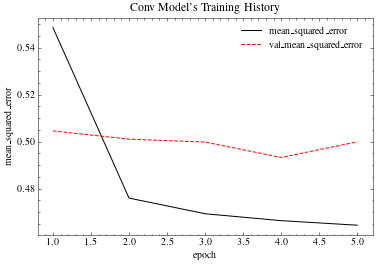

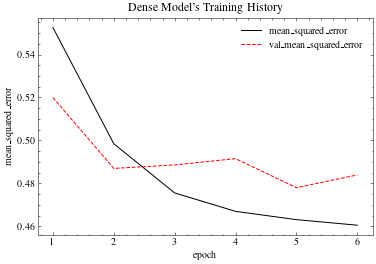

In [10]:
# Plot Model Train History
plt.style.use(['science', 'ieee'])
for container in model_containers:
    savepath = 'figs/ch4_trainhistory_mse_{}.png'.format(
                        os.path.basename(container.model_dir)
                    ).lower()
    container.PlotTrainHistory(metric='mean_squared_error', savepath=savepath)

##### Model's Summary

In [11]:
summaries = []
for container in model_containers:
    summaries.append("Model, {}\n".format(os.path.basename(container.model_dir)))
    container.model.summary(print_fn=lambda x: summaries.append(x+'\n'))

    for layer in container.model.layers:
        print (layer)
        if isinstance(layer, tf.keras.layers.Dropout):
            summaries.append(
                    'for {}, rate: {}\n'.format (layer.name, layer.rate)
                )
            print ('for {}, rate: {}\n'.format (layer.name, layer.rate))

    summaries.append('\n')

summaries = ''.join(summaries)
with open('outs/ch4_models_summaries.txt', 'w') as summary_file:
    summary_file.write(summaries)
summary_file.close()

print ("Summaries written to 'outs/ch4_models_summaries.txt'")

for dropout_1, rate: 0.2

Summaries written to 'outs/ch4_models_summaries.txt'


In [12]:
model_containers[0].test_mae

0.42498666048049927

In [13]:
model_containers[-1].test_mae

0.3639880120754242

In [14]:
model_containers[0].test_mae - model_containers[-1].test_mae

0.06099864840507507

#### Performance Table

In [38]:
model_containers.sort(key=lambda x: x.test_mae, reverse=True)

performance_dict = {}
for container in model_containers:
    performance_dict["Model's Config."] = performance_dict.get("Model's Config.", [])
    performance_dict["Model's Config."].append(os.path.basename(container.model_dir))

    performance_dict["Eval MSE"] = performance_dict.get("Eval MSE", [])
    performance_dict["Eval MSE"].append(container.eval_mse)

    performance_dict["Test MSE"] = performance_dict.get("Test MSE", [])
    performance_dict["Test MSE"].append(container.test_mse)

    performance_dict["Eval MAE"] = performance_dict.get("Eval MAE", [])
    performance_dict["Eval MAE"].append(container.eval_mae)

    performance_dict["Test MAE"] = performance_dict.get("Test MAE", [])
    performance_dict["Test MAE"].append(container.test_mae)

    performance_dict["Unnormalized MAE (elevator)"] = performance_dict.get("Unnormalized MAE (elevator)", [])
    performance_dict["Unnormalized MAE (elevator)"].append(container.unnorm_elv_mae)

    performance_dict["Unnormalized MAE (n1)"] = performance_dict.get("Unnormalized MAE (n1)", [])
    performance_dict["Unnormalized MAE (n1)"].append(container.unnorm_n1s_mae)

performance_df = pd.DataFrame(performance_dict)
performance_df.to_latex('ch4_models_performance.tex', index=False, label='ch4_models_performance')
performance_df

/tmp/ipykernel_33609/2895154845.py:27: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  performance_df.to_latex('ch4_models_performance.tex', index=False, label='ch4_models_performance')


,Model's Config.,Eval MSE,Test MSE,Eval MAE,Test MAE,Unnormalized MAE (elevator),Unnormalized MAE (n1)
0,Baseline,0.607663,0.555207,0.539267,0.504780,1.335346,5.663691
1,LSTM,0.509284,0.436248,0.469189,0.424987,1.349424,3.882287
2,GRU,0.512848,0.412751,0.458910,0.398491,1.327157,3.379026
3,Conv,0.499915,0.398048,0.429428,0.370393,1.326778,2.746861
4,Dense,0.483909,0.385431,0.422167,0.363988,1.324417,2.631756


#### Performance Plot

/tmp/ipykernel_33609/2704463390.py:60: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


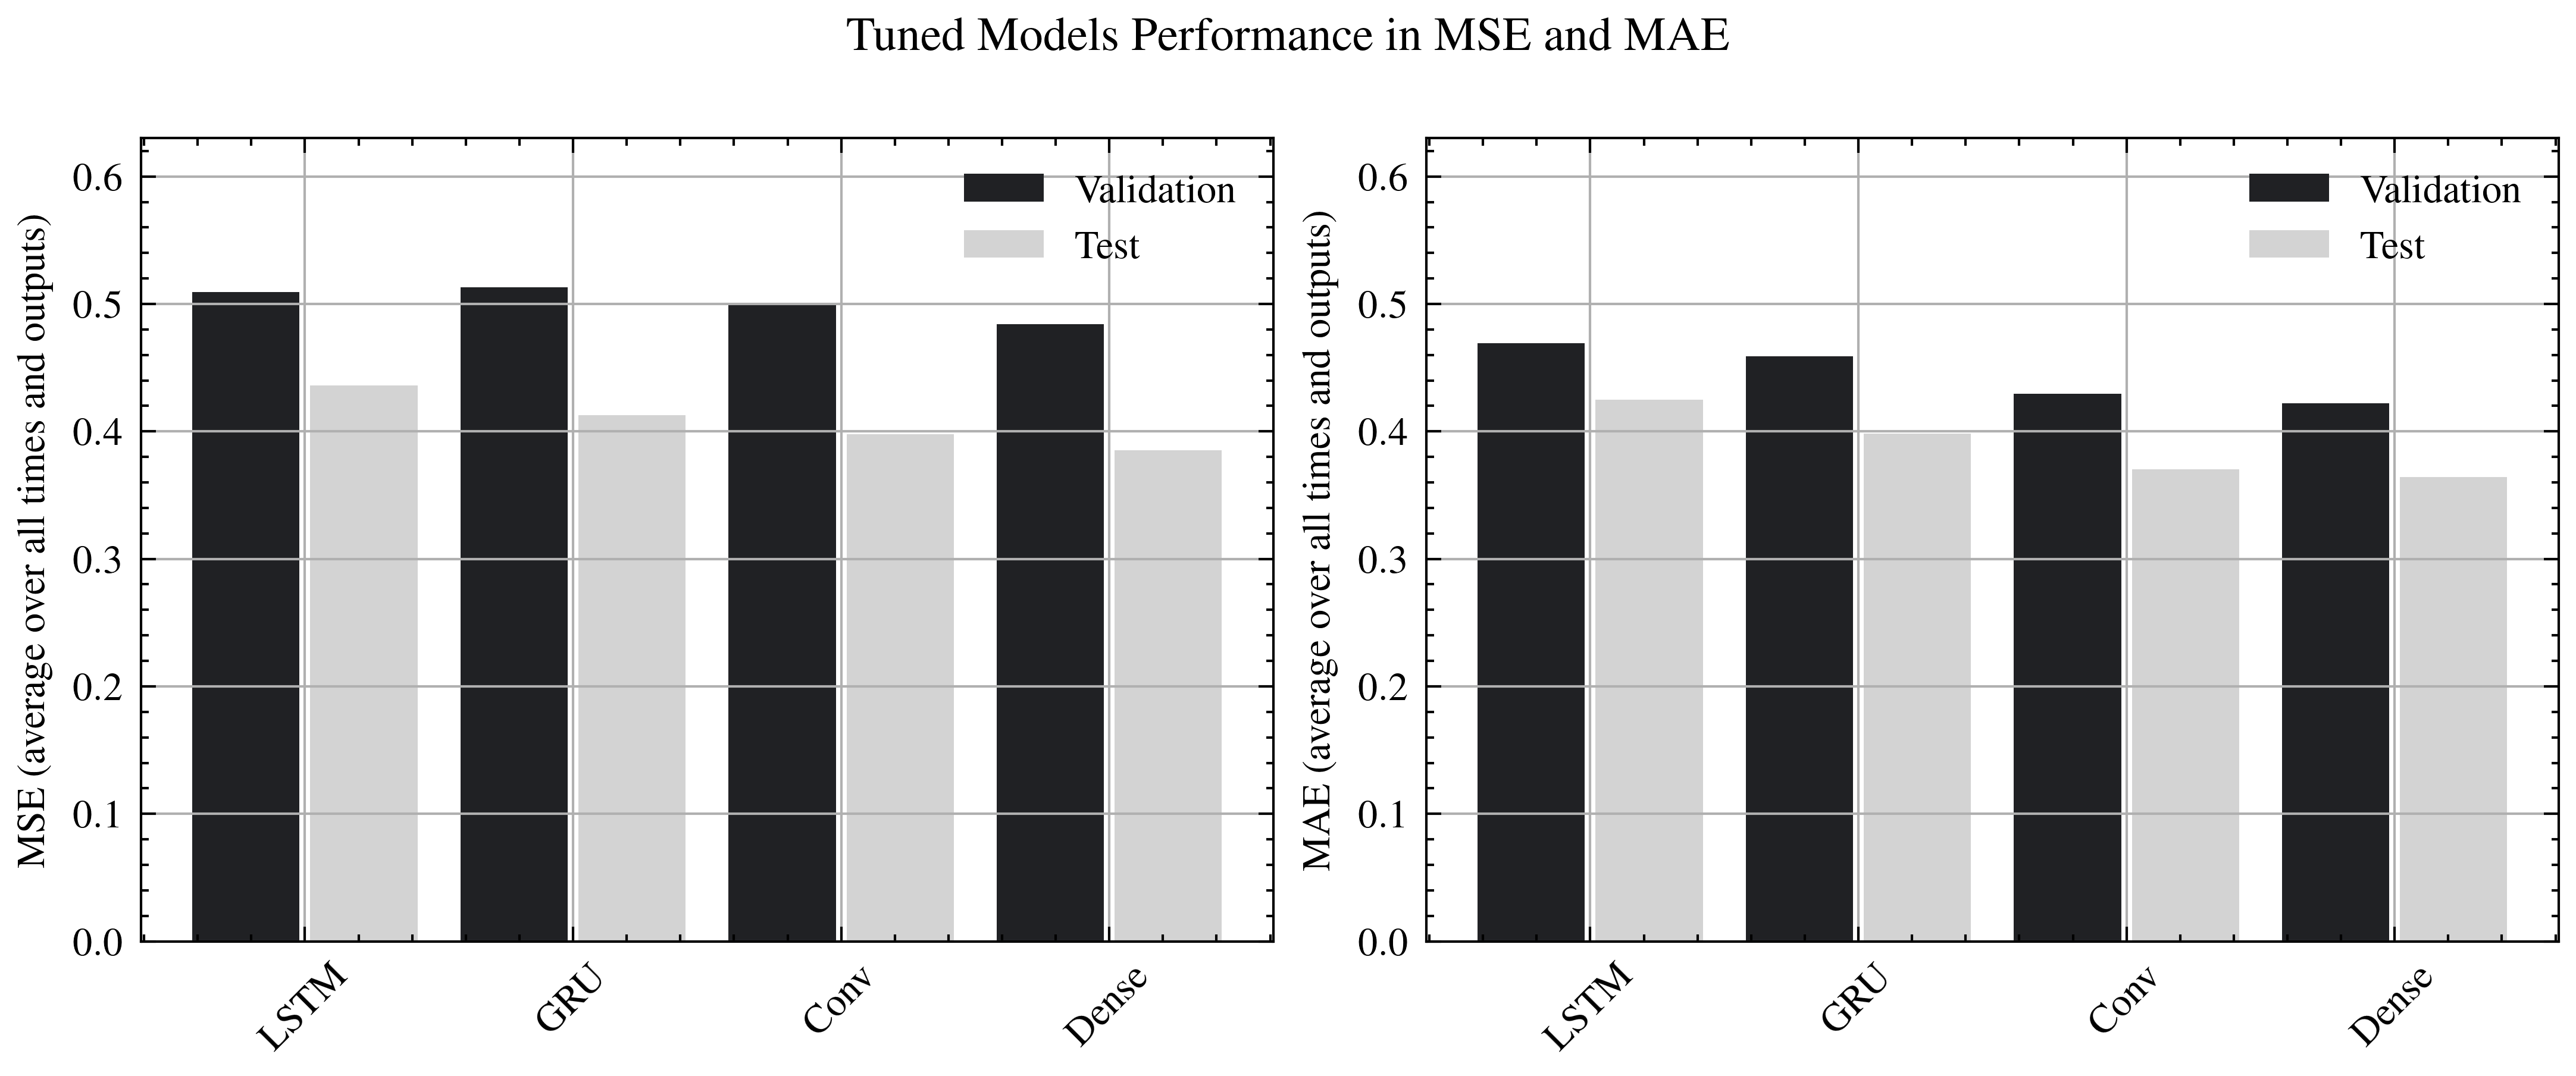

In [16]:
plt.style.use(['science', 'ieee'])
PlotPerformanceComparison(model_containers, width=0.4)

#### Random Samples Prediction

In [17]:
_, test_list = get_file_list()

In [18]:
model_containers

Baseline
LSTM
GRU
Baseline
Conv
Dense


/tmp/ipykernel_33609/945810045.py:108: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


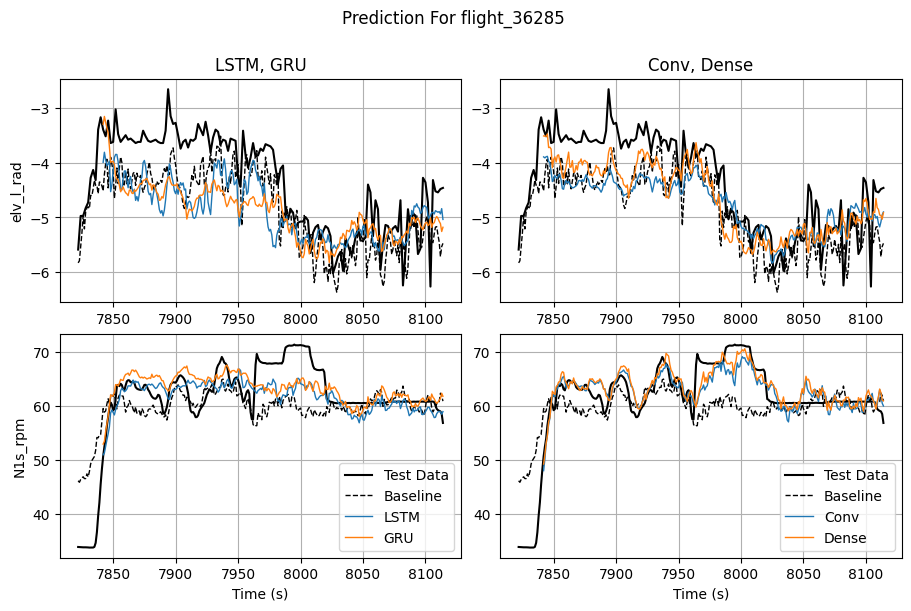

In [27]:
plt.style.use('default')
PlotRandomSamplePredictions(test_list, model_containers, 3, 2, num=1)

Baseline
LSTM
GRU
Baseline
Conv
Dense


/tmp/ipykernel_33609/945810045.py:108: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


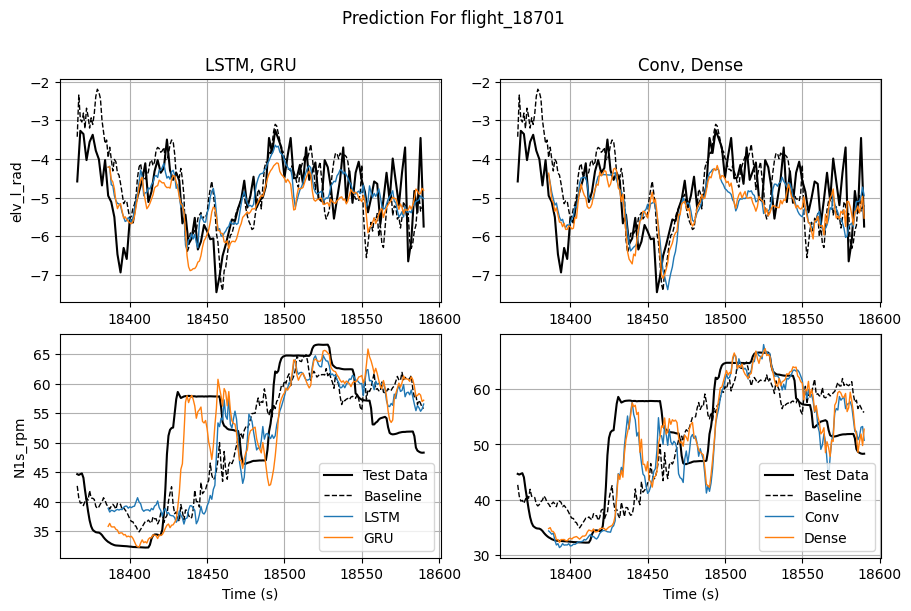

In [28]:
PlotRandomSamplePredictions(test_list, model_containers, 3, 2, num=2)

Baseline
LSTM
GRU
Baseline
Conv
Dense


/tmp/ipykernel_33609/945810045.py:108: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


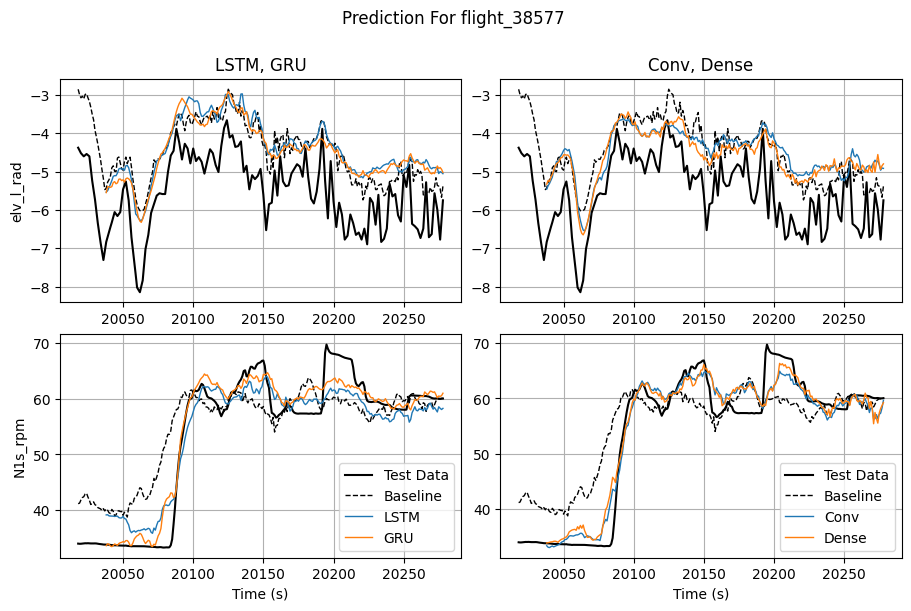

In [29]:
PlotRandomSamplePredictions(test_list, model_containers, 3, 2, num=2)

Baseline
LSTM
GRU
Baseline
Conv
Dense


/tmp/ipykernel_33609/945810045.py:108: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


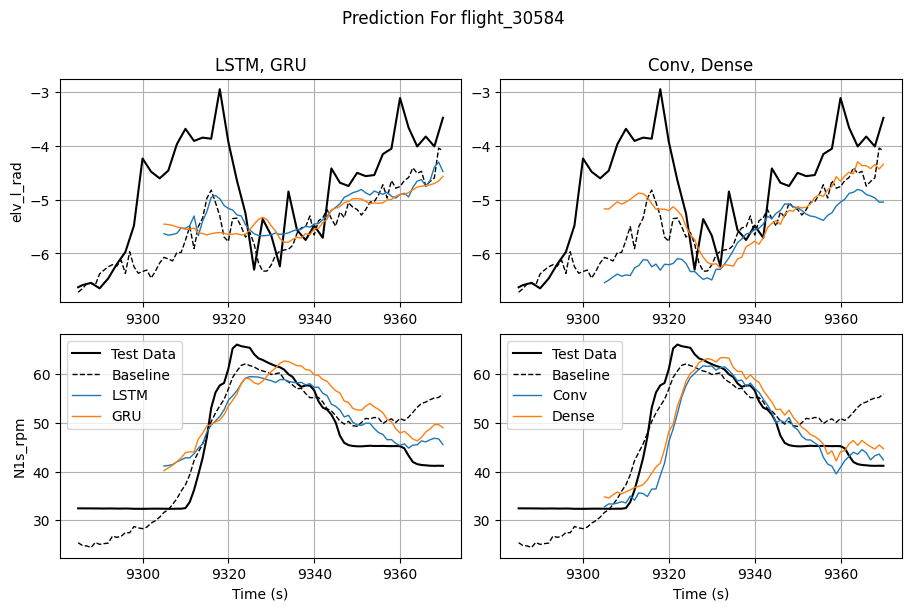

In [30]:
PlotRandomSamplePredictions(test_list, model_containers, 3, 2, num=2)

Baseline
LSTM
GRU
Baseline
Conv
Dense


/tmp/ipykernel_33609/945810045.py:108: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


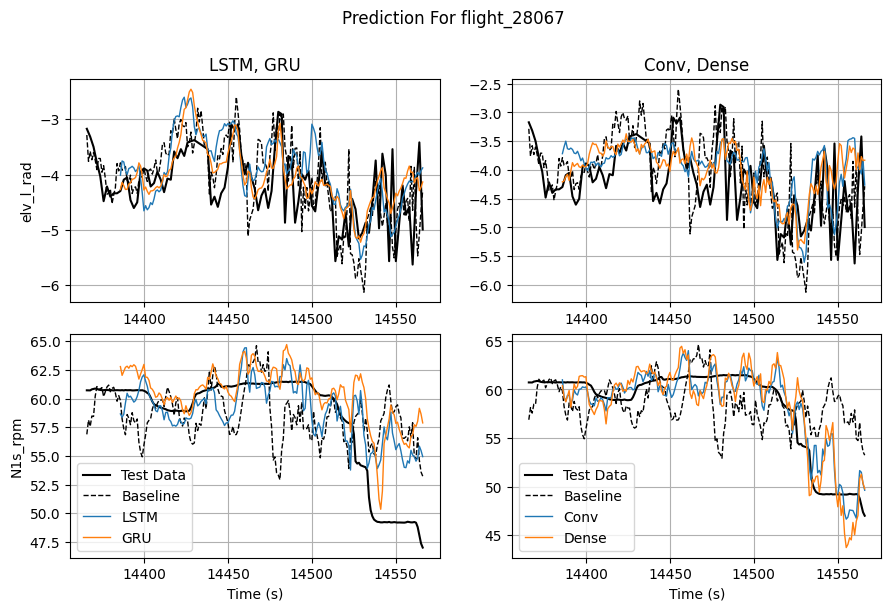

In [31]:
PlotRandomSamplePredictions(test_list, model_containers, 3, 2, num=2)